In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import time 


import logistic_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from collections import defaultdict

np.random.seed(44) # for comparison of results

# Comparison of different optimization methods for logistic regression

In the following notebook, we will compare different optimization methods for logistic regression. We will use one generated dataseta along with many real datasets. We will compare the following optimization methods:
- IWLS (Iteratively Reweighted Least Squares)
- SGD (Stochastic Gradient Descent)
- ADAM (Adaptive Moment Estimation)

We will also compare the performance of the optimization methods using interactions between features and without.

The parameters of the optimization methods are choosen to be default for each method:

## Stopping criterion

To make a comparison fair, we propose the same stopping rule for each algorithm.
We will stop the optimization when the values of the gradient are less than 10^{-3} or when the number of iterations is greater than 500.

CONSIDER DIFFERENT STOPPING RULES

In [6]:
def compare_methods(X, y, algorithms = ["iwls", "sgd", "adam"], k = 5, test_size = 0.2, interaction = False):
    balanced_accuracies = {}
    interaction_opt = [False]
    if interaction:
        interaction_opt.append(True)

    for alg in algorithms:
        balanced_accuracies[alg] = []
        
        print(f"Using algorithm: {alg}" + (" with interactions" if interaction else ""))
        for inter in interaction_opt:
            alg_name = alg + ("_inter" if inter else "")
            for i in range(k):
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
                model = logistic_regression.LogisticRegressor(descent_algorithm = alg, include_interactions = inter)
                model.fit(X_train, y_train, max_num_epoch = 500, tolerance=1e-3)
                balanced_accuracies[alg].append(model.balanced_accuracy(X_test, y_test))
                print(f"Balanced accuracy: {balanced_accuracies[alg_name][-1]}")
            print(f"Mean accuracy: {np.mean(balanced_accuracies[alg_name])}")
    balanced_accuracies = pd.DataFrame(balanced_accuracies)
    return balanced_accuracies

In [7]:
def compare_methods_v2(X, y, algorithms = ["iwls", "sgd", "adam"], k = 5, test_size = 0.2, interaction = False):
    final_metrics = pd.DataFrame(
        columns=[
            "Algorithm",
            "Interactions",
            "AlgorithmInteractions",
            "Balanced Accuracy",
            "Time",
            "run_number",
        ]
    )
    after_epoch_metrics = defaultdict(list)
    interaction_opt = [False]
    if interaction:
        interaction_opt.append(True)

    for alg in algorithms:
        for inter in interaction_opt:
            alg_inter = alg + ("_inter" if inter else "")
            for i in range(k):

                # Split data and create regressor object
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
                model = logistic_regression.LogisticRegressor(descent_algorithm = alg, include_interactions = inter)

                # Fit model and record time
                start = time.perf_counter()
                model.fit(X_train, y_train, max_num_epoch = 500, tolerance=1e-3)
                end = time.perf_counter() - start

                # Record metrics
                loss_after_epoch = model.convergence_rate
                after_epoch_metrics[alg_inter].append(loss_after_epoch)
                final_metrics.loc[len(final_metrics)] = [alg, inter, alg_inter, model.balanced_accuracy(X_test, y_test), end, i+1]
                print(f"Run {i+1} of {alg_inter} completed")
    return final_metrics, after_epoch_metrics
    

## Datasets

### artificial data

In [8]:
import numpy as np
from scipy.special import expit as sigmoid
n = 1000

a = 10

# Generate y observations from the binomial distribution
y = np.random.binomial(1, 0.5, size=n)

true_beta = np.array([5, 3])

X = np.random.normal(size = (n, 2))

y = np.random.binomial(1, sigmoid(X @ true_beta))

np.mean(y)

0.498

In [15]:
final, after_epoch = compare_methods_v2(X, y, interaction = True)

Run 1 of iwls completed
Run 2 of iwls completed
Run 3 of iwls completed
Run 4 of iwls completed
Run 5 of iwls completed
Run 1 of iwls_inter completed
Run 2 of iwls_inter completed
Run 3 of iwls_inter completed
Run 4 of iwls_inter completed
Run 5 of iwls_inter completed
Early stopping criterion reached at epoch 84.
Run 1 of sgd completed
Early stopping criterion reached at epoch 69.
Run 2 of sgd completed
Early stopping criterion reached at epoch 69.
Run 3 of sgd completed
Early stopping criterion reached at epoch 64.
Run 4 of sgd completed
Early stopping criterion reached at epoch 71.
Run 5 of sgd completed
Early stopping criterion reached at epoch 72.
Run 1 of sgd_inter completed
Early stopping criterion reached at epoch 71.
Run 2 of sgd_inter completed
Early stopping criterion reached at epoch 73.
Run 3 of sgd_inter completed
Early stopping criterion reached at epoch 72.
Run 4 of sgd_inter completed
Early stopping criterion reached at epoch 68.
Run 5 of sgd_inter completed
Run 1 of a

Text(0, 0.5, 'log(Loss)')

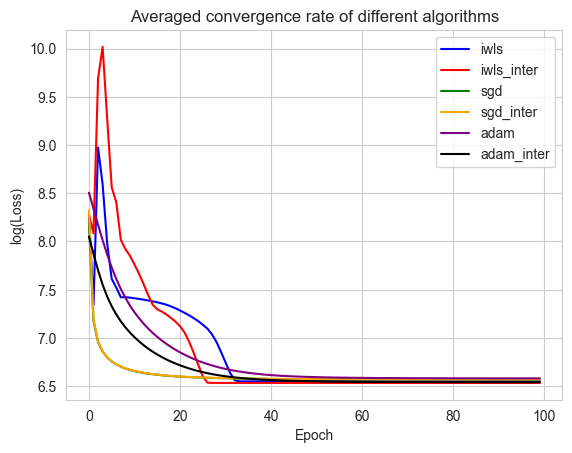

In [19]:
colors = ["blue", "red", "green", "orange", "purple", "black"]
for alg_name, runs in after_epoch.items():
    averaged = np.zeros(501)
    for run in runs:
        for i in range(501):
            if i < len(run):
                averaged[i] += run[i]
            else:
                averaged[i] += run[-1]
    plt.plot(np.log(averaged[:100]), label=alg_name, color=colors[0])
    colors.pop(0)
plt.legend()
plt.title("Averaged convergence rate of different algorithms")
plt.xlabel("Epoch")
plt.ylabel("log(Loss)")

<Axes: xlabel='AlgorithmInteractions', ylabel='Time'>

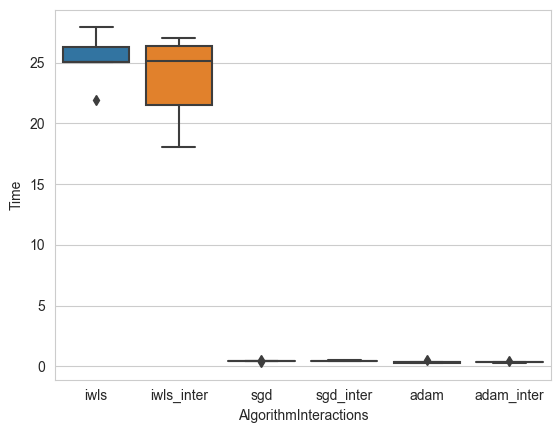

In [20]:
import seaborn as sns
sns.set_style("whitegrid")
sns.boxplot(data=final, x="AlgorithmInteractions", y="Time")

<Axes: xlabel='AlgorithmInteractions', ylabel='Balanced Accuracy'>

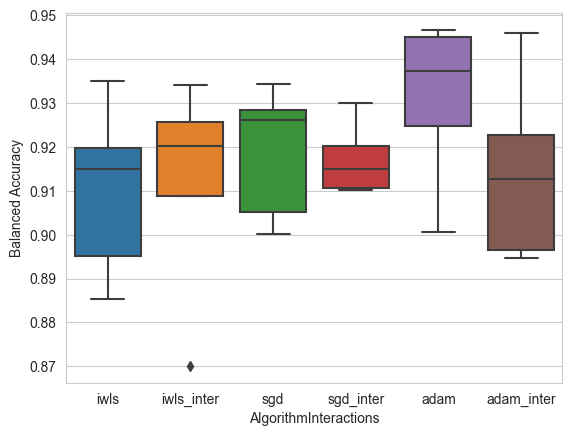

In [21]:
import seaborn as sns

sns.set_style("whitegrid")
sns.boxplot(data=final, x="AlgorithmInteractions", y="Balanced Accuracy")

# Aids

In [6]:
aids = pd.read_csv('data/aids.csv')

y = aids['target']
X = aids.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [7]:
compare_methods(X, y)

Using algorithm: iwls
[9866.98129502168, 8865.804025412312, 6890.03457743989, 6363.412086727263, 5605.906530357304, 5479.3922173121355, 5048.7137792784415, 4814.170383020983, 4738.716197445236, 4805.968167519621, 4826.266011451756, 4821.54820305235, 4758.853622225526, 4643.814630016459, 4536.272934248918, 4418.95081599166, 4238.631490541854, 3737.416268638076, 1251.0218417444682, 24336.878178411833, 5323.27948364746, 4877.825443330553, 4823.295779857602, 4774.465554034741, 4682.991638212278, 4638.504081246355, 4553.113969612946, 4456.717719078952, 4325.145962548924, 4096.928384106116, 3441.300661747828, 6584.948885556172, 4514.143251455434, 2309.8559213877797, 28759.202761614815, 6808.142556167109, 5899.282667631696, 5214.6763211549605, 5106.595891666736, 4985.479064935111, 4731.887937160406, 4662.218159718289, 4445.237373422431, 4270.267932187923, 3644.4803315909157, 1078.9310842138884, 3472.9978103193853, 8220.811434056319, 22002.322397181848, 8083.908130845755, 4888.253578737445, 45

,iwls,sgd,adam
0,0.222098,0.596708,0.826671
1,0.786604,0.527523,0.750842
2,0.757968,0.806821,0.742991
3,0.252484,0.686332,0.603822
4,0.742551,0.508696,0.783509


In [ ]:
lr = logistic_regression.LogisticRegressor(descent_algorithm="sgd")

lr.fit(X_train, y_train, max_num_epoch=100)

y_pred = lr.predict(X_test)
lr.confusion_matrix(X_test, y_test)

IndexError: tuple index out of range

In [ ]:
X_test.columns

Index(['time', 'trt', 'age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof',
       'oprior', 'z30', 'preanti', 'race', 'gender', 'symptom', 'treat',
       'offtrt', 'cd40', 'cd420', 'cd80', 'cd820'],
      dtype='object')

In [ ]:
sklearn_lr = LogisticRegression(max_iter=10000, tol=1e-3, solver='lbfgs')
sklearn_lr.fit(X, y)
sklearn_lr.score(X, y)
y_pred = sklearn_lr.predict(X)

In [ ]:
print(f"Our implementation\n{lr.confusion_matrix(X, y)}")
print(f"Sklearn implementation\n{confusion_matrix(y, y_pred)}")

Our implementation
[[ 182   73]
 [ 339 1545]]
Sklearn implementation
[[1531   87]
 [ 190  331]]


In [ ]:
print(f"Accuracy of our implementation: {lr.accuracy(X_test, y_test)}")
print(f"Accuracy of sklearn implementation: {sklearn_lr.score(X_test, y_test)}")

Accuracy of our implementation: 0.8130841121495327
Accuracy of sklearn implementation: 0.8808411214953271
